# Loading Libraries

In [1]:
import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms, models, datasets  ## models contains the pre trained models
%matplotlib inline

import seaborn as sns
import torch.nn.functional as F


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import face_alignment

In [5]:
import os
from PIL import Image
import cv2
from glob import glob
from copy import deepcopy



In [6]:
from sklearn import cluster
from mpl_toolkits.mplot3d import Axes3D
root_dir = "4"

# VGG : Visual Geometric Group. Takes imput as (224,224,3)

In [4]:
model = models.vgg16(weights= True, progress=True)

c:\Users\rachi\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
print(summary(model, torch.zeros((1,3,224,224))))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

# VGG on cats and dogs

In [6]:
train_dir = "3\\catsanddogs\\PetImages\\training"
test_dir = "3\\catsanddogs\\PetImages\\testing"

In [7]:
#### cleaning the dataset
cat_files_dir = os.path.join(train_dir, "Cat")
cats_tr = glob(cat_files_dir+"\*.jpg")
        
dog_files_dir = os.path.join(train_dir, "Dog")
dogs_tr = glob(dog_files_dir+"\*.jpg")


cat_files_dir = os.path.join(test_dir, "Cat")
cats_val = glob(cat_files_dir+"\*.jpg")
        
dog_files_dir = os.path.join(test_dir, "Dog")
dogs_val = glob(dog_files_dir+"\*.jpg")


In [8]:
#folders = [cats_tr, dogs_tr, cats_val, dogs_val]

#for folder in folders:
#    for path in folder:
#        im = cv2.imread(path)
#        if im is None:
#            os.remove(path)
#            print(f"removed: {path}")

In [9]:
transforms.Normalize?

Init signature: transforms.Normalize(mean, std, inplace=False)
Docstring:     
Normalize a tensor image with mean and standard deviation.
This transform does not support PIL Image.
Given mean: ``(mean[1],...,mean[n])`` and std: ``(std[1],..,std[n])`` for ``n``
channels, this transform will normalize each channel of the input
``torch.*Tensor`` i.e.,
``output[channel] = (input[channel] - mean[channel]) / std[channel]``

.. note::
    This transform acts out of place, i.e., it does not mutate the input tensor.

Args:
    mean (sequence): Sequence of means for each channel.
    std (sequence): Sequence of standard deviations for each channel.
    inplace(bool,optional): Bool to make this operation in-place.
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File:           c:\users\rachi\anaconda3\lib\site-packages\torchvision\transforms\transforms.py
Type:           type
Subclasses:     


##### While leveraging pre-trained models, it is mandatory to resize, permute and normalize, where images are scaled b.w 0 and 1 across 3 channels and then normalized to mean of [0.485,0.456,0.406] and standard deviations : [0.229,0.224, 0.225]

In [148]:
class cats_dogs(Dataset):
    
    def __init__(self, root_dir):
        cat_files_dir = os.path.join(root_dir, "Cat")
        cats = glob(cat_files_dir+"\*.jpg")
        
        dog_files_dir = os.path.join(root_dir, "Dog")
        dogs = glob(dog_files_dir+"\*.jpg")
        
        
        ### combining all files
        self.fpaths = dogs + cats
        self.normalize = transforms.Normalize(mean=[0.485,0.456,0.406], std = [0.229,0.224, 0.225])
        
        #### shuffling all the files
        from random import shuffle
        shuffle(self.fpaths)
        
        
        #### Creating target , Dog = 1, Cat = 0
        self.targets = [int('Dog' in file) for file in self.fpaths]
        
        
        
    def __len__(self):
        return len(self.fpaths)
    
    def __getitem__(self, index):
        f = self.fpaths[index]
        target = self.targets[index]
        
        ### Reading image and converting to rgb
        #im = plt.imread(f)
        im = cv2.imread(f)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = cv2.resize(im, (224,224)) 
        #im = cv2.resize(im, (64,64))
        im = torch.tensor(im/255).permute(2,0,1)
        im = self.normalize(im)
        
        
        
        
        
        
        
        return im.float().to(device), torch.tensor([target]).float().to(device)
    
        
    
        
    
        
        
        
        
        
        
        

In [149]:
trn_ds = cats_dogs(train_dir)
val_ds = cats_dogs(test_dir)

In [150]:
len(trn_ds)

8072

In [157]:
index = np.random.choice(len(trn_ds))

In [158]:
im, label = trn_ds[index]

In [159]:
im.shape 

torch.Size([3, 224, 224])

In [160]:
label

tensor([0.], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


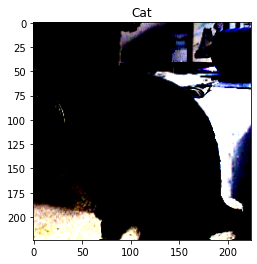

In [161]:
### permuting so that shape is 224,224,3

plt.imshow(im.permute(1,2,0).cpu())
plt.title(f"{'Dog' if label==1 else 'Cat'}")

plt.show()

In [162]:
model.parameters()

<generator object Module.parameters at 0x000002AE49CDF0B0>

In [163]:
for param in model.parameters():
    print(param.requires_grad, end = " ") # set this to false for all the parameters

False False False False False False False False False False False False False False False False False False False False False False False False False False True True True True True True 

In [164]:
print(model) ## Will change classifier part of this model within the model class

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [165]:
def get_model():
    model = models.vgg16(weights=True, progress=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))  ### will return (512,1,1) instead of (512,7,7)
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,64),
        nn.ReLU(),
        nn.Linear(64,1),  #### Here, the last ouput should be 1 and not 2 as we are using BCEloss
        nn.Sigmoid()
    )
    
    loss_fn = nn.BCELoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    return model.to(device), loss_fn, optimizer
    
    

In [166]:
model, loss_fn, optimizer = get_model()

c:\Users\rachi\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [167]:
loss_fn

BCELoss()

In [168]:
print(summary(model, torch.zeros(1,3,224,224)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

In [169]:
def train_batch(x,y,model,optimizer,loss_fn):
    model.train()
    _y = model(x)
    
    #print(y)
    batch_loss = loss_fn(_y,y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    return batch_loss.item()


In [170]:
@torch.no_grad()
def accuracy(x,y,model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction>0.5) == y
    return is_correct.cpu().numpy().tolist()

In [171]:
def get_data():
    train = cats_dogs(train_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)
    
    val = cats_dogs(test_dir)
    val_dl = DataLoader(val, batch_size=32, drop_last=True)
    return trn_dl, val_dl

In [172]:
trn_dl, val_dl = get_data()

In [173]:
@torch.no_grad()
def val_loss(x,y,model):
    prediction = model(x)
    
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [174]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(2):
    print(f"epoch: {epoch}")
    
    train_epoch_losses, train_epoch_accuracies = [], []
    
    print("training")
    for ix, batch in enumerate(iter(trn_dl)):
        
        x, y = batch
        
   
        batch_loss = train_batch(x,y,model, optimizer,loss_fn)
        if ix % 50 == 0:
            print(f"epoch: {epoch} - batch: {ix}, loss: {batch_loss}")

        train_epoch_losses.append(batch_loss)
    
    print("========================================")
        
    train_epoch_loss = np.array(train_epoch_losses).mean()
    
    print("Getting Accuracy on Training data")
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x,y, model)
        
        
        train_epoch_accuracies.extend(is_correct)
    print("========================================")
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    
    print("Getting Accuracy on validation data:")
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x,y, model)
        validation_loss =  val_loss(x,y,model)
    print("========================================")
    
    
    
    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)
    
    
    print(f"Current loss: {train_epoch_loss}" )
    print(f"Current accuracy: {train_epoch_accuracy}")
    print(f"Current validation loss: {validation_loss}")
    print(f"Current validation accuracy: {val_epoch_accuracy}")

epoch: 0
training
epoch: 0 - batch: 0, loss: 0.6812968254089355
epoch: 0 - batch: 50, loss: 0.017034661024808884
epoch: 0 - batch: 100, loss: 0.020700762048363686
epoch: 0 - batch: 150, loss: 0.011421536095440388
epoch: 0 - batch: 200, loss: 0.05292525142431259
epoch: 0 - batch: 250, loss: 0.0201371181756258
Getting Accuracy on Training data
Getting Accuracy on validation data:
Current loss: 0.06557639513283946
Current accuracy: 0.9862351190476191
Current validation loss: 0.06959030032157898
Current validation accuracy: 0.96875
epoch: 1
training
epoch: 1 - batch: 0, loss: 0.004324772395193577
epoch: 1 - batch: 50, loss: 0.026066143065690994
epoch: 1 - batch: 100, loss: 0.10692200809717178
epoch: 1 - batch: 150, loss: 0.021368075162172318
epoch: 1 - batch: 200, loss: 0.004574773833155632
epoch: 1 - batch: 250, loss: 0.0180243868380785
Getting Accuracy on Training data
Getting Accuracy on validation data:
Current loss: 0.03382087520800442
Current accuracy: 0.9887152777777778
Current vali

In [175]:
ix = np.random.choice(len(val_ds))

In [176]:
img, label = val_ds[ix]

In [177]:
label

tensor([0.], device='cuda:0')

In [178]:
pred = model.to("cpu")(img.unsqueeze(0).cpu().detach())

In [179]:
pred

tensor([[0.0002]], grad_fn=<SigmoidBackward0>)

In [180]:
threshold = 0.5
prediction = 0 if pred<threshold else 1

In [181]:
prediction

0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


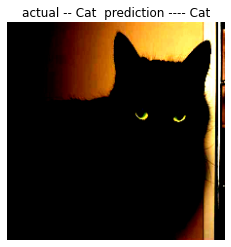

In [182]:
plt.imshow(img.cpu().permute(1,2,0))
plt.title(f"actual -- {'Dog' if label == 1 else 'Cat'}  prediction ---- {'Dog' if prediction==1 else 'Cat'}")
plt.axis("off")
plt.show()

In [183]:
cat_path = "2\Felis_catus-cat_on_snow.jpg"

In [184]:
img = plt.imread(cat_path)

In [185]:
img = cv2.resize(img, (224,224))

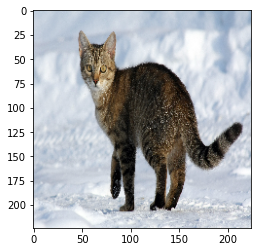

In [186]:
plt.imshow(img)

In [187]:
img_tensor = torch.tensor(img, dtype=torch.float32)

In [188]:
img_tensor = img_tensor/255

In [189]:
img_tensor.shape

torch.Size([224, 224, 3])

In [190]:
img_tensor = img_tensor.permute(2,0,1)

In [191]:
img_tensor.shape

torch.Size([3, 224, 224])

In [192]:
img_tensor = img_tensor.unsqueeze(0)

In [193]:
img_tensor.dtype

torch.float32

In [194]:
model(img_tensor)

tensor([[0.4267]], grad_fn=<SigmoidBackward0>)

# RESNET


Problems with deeper CNNs:

1. The information from initial layers doesn't reach later layers. Basicaly the info abt initial layers gets lost before reaching final layers.

2. Vanishing Gradients Problem: The initial layer weights are not updated that much because gradients for initial layers nearly become 0


RESNET helps here, info from initial layer is fed to latyer layer in addition to the conv layer output

##### RESNET block

In [4]:
class ResLayer(nn.Module):
    def __init__(self, ni, no, kernel_size, stride = 1):
        super(ResLayer,self).__init__()
        padding = kernel_size - 2 ### adding this padding so that input shape and outer shape remain same
        
        self.conv = nn.Sequential(
            nn.Conv2d(ni,no,kernel_size, stride, padding),
            nn.ReLU()
        )
    
    def forward(self,x):
        return self.conv(x) + x
        

##### cats and dogs with Resnet18

In [5]:
train_dir = "3\\catsanddogs\\PetImages\\training"
test_dir = "3\\catsanddogs\\PetImages\\testing"

In [6]:
#### cleaning the dataset
cat_files_dir = os.path.join(train_dir, "Cat")
cats_tr = glob(cat_files_dir+"\*.jpg")
        
dog_files_dir = os.path.join(train_dir, "Dog")
dogs_tr = glob(dog_files_dir+"\*.jpg")


cat_files_dir = os.path.join(test_dir, "Cat")
cats_val = glob(cat_files_dir+"\*.jpg")
        
dog_files_dir = os.path.join(test_dir, "Dog")
dogs_val = glob(dog_files_dir+"\*.jpg")


In [7]:
#folders = [cats_tr, dogs_tr, cats_val, dogs_val]

#for folder in folders:
#    for path in folder:
#        im = cv2.imread(path)
#        if im is None:
#            os.remove(path)
#            print(f"removed: {path}")

In [8]:
class cats_dogs(Dataset):
    
    def __init__(self, root_dir):
        cat_files_dir = os.path.join(root_dir, "Cat")
        cats = glob(cat_files_dir+"\*.jpg")
        
        dog_files_dir = os.path.join(root_dir, "Dog")
        dogs = glob(dog_files_dir+"\*.jpg")
        
        
        ### combining all files
        self.fpaths = dogs + cats
        self.normalize = transforms.Normalize(mean=[0.485,0.456,0.406], std = [0.229,0.224, 0.225])
        
        #### shuffling all the files
        from random import shuffle
        shuffle(self.fpaths)
        
        
        #### Creating target , Dog = 1, Cat = 0
        self.targets = [int('Dog' in file) for file in self.fpaths]
        
        
        
    def __len__(self):
        return len(self.fpaths)
    
    def __getitem__(self, index):
        f = self.fpaths[index]
        target = self.targets[index]
        
        ### Reading image and converting to rgb
        #im = plt.imread(f)
        im = cv2.imread(f)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = cv2.resize(im, (224,224)) 
        #im = cv2.resize(im, (64,64))
        im = torch.tensor(im/255).permute(2,0,1)
        im = self.normalize(im)
        
        
        
        
        
        
        
        return im.float().to(device), torch.tensor([target]).float().to(device)
    
        
    
        
    
        
        
        
        
        
        
        

In [9]:
trn_ds = cats_dogs(train_dir)
val_ds = cats_dogs(test_dir)

In [10]:
len(trn_ds)

8072

In [11]:
index = np.random.choice(len(trn_ds))

In [12]:
im, label = trn_ds[index]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


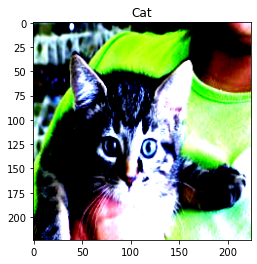

In [13]:
### permuting so that shape is 224,224,3

plt.imshow(im.permute(1,2,0).cpu())
plt.title(f"{'Dog' if label==1 else 'Cat'}")

plt.show()

In [62]:
def get_model():
    model = models.resnet18(weights=True, progress=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))  ### will return (512,1,1) instead of (512,7,7)
    model.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256,64),
        nn.ReLU(),
        nn.Linear(64,1),  #### Here, the last ouput should be 1 and not 2 as we are using BCEloss
        nn.Sigmoid()
    )
    
    loss_fn = nn.BCELoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    return model.to(device), loss_fn, optimizer
    
    

In [63]:
model, loss_fn, optimizer = get_model()

c:\Users\rachi\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [64]:
print(summary(model, torch.zeros(1,3,224,224)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

In [65]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [66]:
def train_batch(x,y,model,optimizer,loss_fn):
    model.train()
    _y = model(x)
    
    
    batch_loss = loss_fn(_y,y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    return batch_loss.item()


In [67]:
@torch.no_grad()
def accuracy(x,y,model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction>0.5) == y
    return is_correct.cpu().numpy().tolist()

In [68]:
def get_data():
    train = cats_dogs(train_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)
    
    val = cats_dogs(test_dir)
    val_dl = DataLoader(val, batch_size=32, drop_last=True)
    return trn_dl, val_dl

In [69]:
trn_dl, val_dl = get_data()

In [70]:
@torch.no_grad()
def val_loss(x,y,model):
    prediction = model(x)
    
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [71]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(2):
    print(f"epoch: {epoch}")
    
    train_epoch_losses, train_epoch_accuracies = [], []
    
    print("training")
    for ix, batch in enumerate(iter(trn_dl)):
        
        x, y = batch
        
   
        batch_loss = train_batch(x,y,model, optimizer,loss_fn)
        if ix % 50 == 0:
            print(f"epoch: {epoch} - batch: {ix}, loss: {batch_loss}")

        train_epoch_losses.append(batch_loss)
    
    print("========================================")
        
    train_epoch_loss = np.array(train_epoch_losses).mean()
    
    print("Getting Accuracy on Training data")
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x,y, model)
        
        
        train_epoch_accuracies.extend(is_correct)
    print("========================================")
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    
    print("Getting Accuracy on validation data:")
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x,y, model)
        validation_loss =  val_loss(x,y,model)
    print("========================================")
    
    
    
    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)
    
    
    print(f"Current loss: {train_epoch_loss}" )
    print(f"Current accuracy: {train_epoch_accuracy}")
    print(f"Current validation loss: {validation_loss}")
    print(f"Current validation accuracy: {val_epoch_accuracy}")

epoch: 0
training
epoch: 0 - batch: 0, loss: 0.6928725242614746
epoch: 0 - batch: 50, loss: 0.30618345737457275
epoch: 0 - batch: 100, loss: 0.0730523094534874
epoch: 0 - batch: 150, loss: 0.06899964809417725
epoch: 0 - batch: 200, loss: 0.17630113661289215
epoch: 0 - batch: 250, loss: 0.05965933948755264
Getting Accuracy on Training data
Getting Accuracy on validation data:
Current loss: 0.1321799523337552
Current accuracy: 0.9816468253968254
Current validation loss: 0.1499783992767334
Current validation accuracy: 0.96875
epoch: 1
training
epoch: 1 - batch: 0, loss: 0.03224636986851692
epoch: 1 - batch: 50, loss: 0.0868280902504921
epoch: 1 - batch: 100, loss: 0.07085290551185608
epoch: 1 - batch: 150, loss: 0.12074892222881317
epoch: 1 - batch: 200, loss: 0.03395344316959381
epoch: 1 - batch: 250, loss: 0.09835713356733322
Getting Accuracy on Training data
Getting Accuracy on validation data:
Current loss: 0.08624207984382612
Current accuracy: 0.9828869047619048
Current validation lo

# Facial Key Point Detection

In [6]:
os.makedirs(root_dir,exist_ok=True)

In [7]:
os.chdir(root_dir)

In [8]:
#!git clone https://github.com/udacity/P1_Facial_Keypoints.git

In [9]:
os.chdir("..")

In [10]:
facial_key_pts_root_dir = "4\\P1_Facial_Keypoints\\data\\training"

In [11]:
all_img_paths = glob(os.path.join(facial_key_pts_root_dir,"*.jpg"))

In [12]:
len(all_img_paths)

3462

In [13]:
data = pd.read_csv("4\\P1_Facial_Keypoints\\data\\training_frames_keypoints.csv")

In [14]:
data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [58]:
class FaceDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df
        self.normalize = transforms.Normalize(mean=[0.485, 0.456,0.406], std=[0.229,0.224,0.225])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, ix):
        
        img_path = os.path.join(facial_key_pts_root_dir, self.df.iloc[ix,0])
        img = cv2.imread(img_path)/255.  # float converts the data to float on its own
        
    
        kp = deepcopy(self.df.iloc[ix,1:].to_list())
        kp_x = (np.array(kp[0::2])/img.shape[1]).tolist()
        kp_y = (np.array(kp[1::2])/img.shape[0]).tolist()
        kp2 = kp_x + kp_y
        

        kp2 = torch.tensor(kp2)
        
        
        img = self.preprocess_input(img)
        return img, kp2
        
    def preprocess_input(self,img):
        #img = cv2.cvtColor(img,) ## check if this reqd or not
        #plt.imshow(plt.imread(img))
        #print(img.shape)
        img  =cv2.resize(img, (224,224))
        img = torch.tensor(img).permute(2,0,1)
        img = self.normalize(img).float()
        return img.to(device)
    
    
    def load_img(self,ix):
        ## helps while testing images
        img_path = os.path.join(facial_key_pts_root_dir, self.df.iloc[ix,0])
        img = cv2.imread(img_path)
        img =cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.
        img = cv2.resize(img, (224,224))
        return img
                

In [59]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

train_dataset = FaceDataset(train.reset_index(drop=True))
test_dataset = FaceDataset(test.reset_index(drop=True))



In [60]:
train_loader = DataLoader(train_dataset, batch_size = 32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [26]:
def get_model():
    model = models.vgg16(weights=True, progress=True)
    
    for param in model.parameters():
        param.requires_grad = False
    
    model.avgpool = nn.Sequential(
        nn.Conv2d(512,512,3),
        nn.MaxPool2d(2),
        nn.Flatten()
    )
    
    model.classifier = nn.Sequential(
        nn.Linear(2048,512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512,136),
        nn.Sigmoid()   ## All values are b.w 0 and 1
    )
    
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
    
    return model.to(device), criterion, optimizer

In [27]:
model, criterion, optimizer = get_model()

c:\Users\rachi\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
def train_batch(img,kps,model,optimizer,loss_fn):
    ### changes made
    model.train()
    
    optimizer.zero_grad()
    _kps = model(img.to(device))
    loss = criterion(_kps, kps.to(device))
    
    loss.backward()
    optimizer.step()
    return loss
    

In [29]:
@torch.no_grad()
def validate_batch(img, kps, model, criterion):
    model.eval()
    _kps = model(img.to(device))
    loss = criterion(_kps, kps.to(device))
    return _kps, loss

In [61]:
train_loss, test_loss = [], []
n_epochs = 50

for epoch in range(n_epochs):
    print(f" epoch {epoch+ 1} : 50")
    epoch_train_loss, epoch_test_loss = 0, 0
    for ix, (img,kps) in enumerate(train_loader):
        loss = train_batch(img, kps, model, optimizer, criterion)
        epoch_train_loss += loss.item() 
    epoch_train_loss /= (ix+1)

    for ix,(img,kps) in enumerate(test_loader):
        ps, loss = validate_batch(img, kps, model, criterion)
        epoch_test_loss += loss.item() 
    epoch_test_loss /= (ix+1)

    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)

 epoch 1 : 50
 epoch 2 : 50
 epoch 3 : 50
 epoch 4 : 50
 epoch 5 : 50
 epoch 6 : 50
 epoch 7 : 50
 epoch 8 : 50
 epoch 9 : 50
 epoch 10 : 50
 epoch 11 : 50
 epoch 12 : 50
 epoch 13 : 50
 epoch 14 : 50
 epoch 15 : 50
 epoch 16 : 50
 epoch 17 : 50
 epoch 18 : 50
 epoch 19 : 50
 epoch 20 : 50
 epoch 21 : 50
 epoch 22 : 50
 epoch 23 : 50
 epoch 24 : 50
 epoch 25 : 50
 epoch 26 : 50
 epoch 27 : 50
 epoch 28 : 50
 epoch 29 : 50
 epoch 30 : 50
 epoch 31 : 50
 epoch 32 : 50
 epoch 33 : 50
 epoch 34 : 50
 epoch 35 : 50
 epoch 36 : 50
 epoch 37 : 50
 epoch 38 : 50
 epoch 39 : 50
 epoch 40 : 50
 epoch 41 : 50
 epoch 42 : 50
 epoch 43 : 50
 epoch 44 : 50
 epoch 45 : 50
 epoch 46 : 50
 epoch 47 : 50
 epoch 48 : 50
 epoch 49 : 50
 epoch 50 : 50


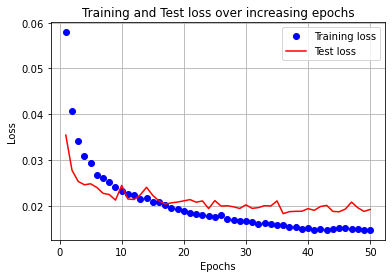

In [62]:

epochs = np.arange(50)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

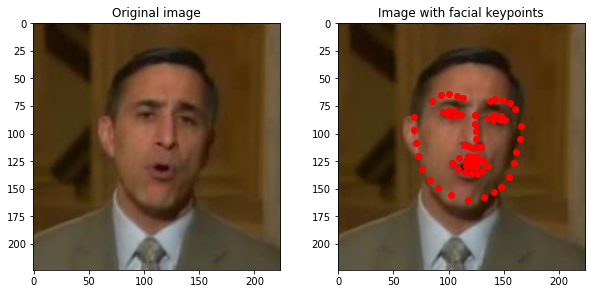

In [70]:
ix = np.random.choice(len(test_loader))
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Original image')
im = test_dataset.load_img(ix)
plt.imshow(im)
plt.grid(False)
plt.subplot(222)
plt.title('Image with facial keypoints')
x, _ = test_dataset[ix]
plt.imshow(im)
kp = model(x[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid(False)
plt.show()

# Pre-trained model for 2d-3d keypointy detection

In [101]:
img_path = "4\\Aishwarya_Rai_12.jpg"

In [81]:
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False, device='cpu')

Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to C:\Users\rachi/.cache\torch\hub\checkpoints\s3fd-619a316812.pth


  0%|          | 0.00/85.7M [00:00<?, ?B/s]

Downloading: "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-cd938726ad.zip" to C:\Users\rachi/.cache\torch\hub\checkpoints\2DFAN4-cd938726ad.zip


  0%|          | 0.00/91.9M [00:00<?, ?B/s]

In [82]:
input = cv2.imread(img_path)

In [102]:
input = cv2.resize(input, (64,64))

In [103]:
preds = fa.get_landmarks(input)

In [104]:
preds = preds[0]  ## returns the final output on the basis of image size

In [105]:
preds.shape

(68, 2)

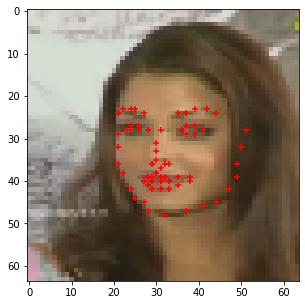

In [106]:
fig, ax = plt.subplots(figsize = (5,5))
plt.imshow(cv2.cvtColor(input, cv2.COLOR_BGR2RGB))
ax.scatter(preds[:,0], preds[:,1], marker='+', c = 'r')
plt.show()


In [107]:
preds.max()

51.0

In [108]:
preds.min()

21.0

# Multi Task Learning

Predicts several connected but different outputs. Ex : in autonomous cars, model identifies objects, obstacles, plan routes, give proper amt of throttle etc.

This needs to be done with minimal latency and on the basis of same set of inputs.

This type of learning greatly helps in Object Detection

link to datset:  https://www.kaggle.com/datasets/nipunarora8/age-gender-and-ethnicity-face-data-csv

In [7]:
age_gender_path = r"4\age_gender\age_gender.csv"

In [8]:
df = pd.read_csv(age_gender_path)

In [9]:
df.head(1)

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...


#### All images are 48*48 in size

In [10]:
img = df.iloc[-1]['pixels']

In [11]:
img  = img.split(" ")

In [12]:
img  = np.reshape(img , (48,48))

In [13]:
img = np.asarray(img, dtype=np.float32)

In [14]:
img = cv2.resize(img,(224,224))

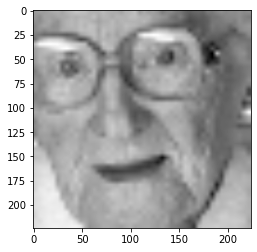

In [15]:
plt.imshow(img, cmap='gray')

In [16]:
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

In [17]:
img.shape

(224, 224, 3)

In [18]:
img

array([[[156.     , 156.     , 156.     ],
        [156.     , 156.     , 156.     ],
        [156.17857, 156.17857, 156.17857],
        ...,
        [145.89285, 145.89285, 145.89285],
        [146.     , 146.     , 146.     ],
        [146.     , 146.     , 146.     ]],

       [[156.     , 156.     , 156.     ],
        [156.     , 156.     , 156.     ],
        [156.17857, 156.17857, 156.17857],
        ...,
        [145.89285, 145.89285, 145.89285],
        [146.     , 146.     , 146.     ],
        [146.     , 146.     , 146.     ]],

       [[155.89285, 155.89285, 155.89285],
        [155.89285, 155.89285, 155.89285],
        [156.05486, 156.05486, 156.05486],
        ...,
        [145.40433, 145.40433, 145.40433],
        [145.5    , 145.5    , 145.5    ],
        [145.5    , 145.5    , 145.5    ]],

       ...,

       [[212.03572, 212.03572, 212.03572],
        [212.03572, 212.03572, 212.03572],
        [212.23851, 212.23851, 212.23851],
        ...,
        [174.15944, 174.15

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


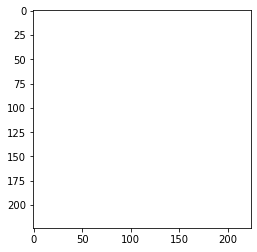

In [19]:
plt.imshow(img)

In [20]:
df['age'].max() ## Will divide age by this number so that everything falls under 1

116

In [21]:
df.iloc[0].squeeze()

age                                                          1
ethnicity                                                    2
gender                                                       0
img_name                        20161219203650636.jpg.chip.jpg
pixels       129 128 128 126 127 130 133 135 139 142 145 14...
Name: 0, dtype: object

In [22]:
df.iloc[3].squeeze

<bound method NDFrame.squeeze of age                                                          1
ethnicity                                                    2
gender                                                       0
img_name                        20161220144911423.jpg.chip.jpg
pixels       193 197 198 200 199 200 202 203 204 205 208 21...
Name: 3, dtype: object>

In [145]:
IMAGE_SIZE = 224 # desired by vgg 16
class GenderAgeClass(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df
        self.normalize = transforms.Normalize(mean  = [0.485, 0.456, 0.406], std=[0.229,0.224,0.225])

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        # not exactly same as book
        
        f = self.df.iloc[index]
        
        gender = f['gender']
        
        age = f['age']
        
        ### get image array
        img_arr = f['pixels'] # will convert this to image in collate fn
        
        
        
        img  = img_arr.split(" ")
        
        
        return gender, age, img
    
    def preprocess_img(self, img):
        img = np.reshape(img, (48,48))
        img = np.asarray(img, np.float32)
        
        img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE))
        
        
        ## converting grayscale to rgb
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        
        
        img = torch.tensor(img).permute(2,0,1)
        
        img = self.normalize(img/255.)
        
        return img[None]
    
    
    def collate_fn(self, batch):
        
        imgs, ages, genders = [],[],[]
        
        for gender, age, img in batch:
            img = self.preprocess_img(img)
            imgs.append(img)
            
            ages.append(float(int(age)/116))
            
            genders.append(gender)

        ages, genders = [torch.tensor(x).to(device).float() for x in [ages, genders]]
        imgs = torch.cat(imgs).to(device)
        
        return imgs, ages, genders
        

In [118]:
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=42)

In [119]:
train = GenderAgeClass(train_df.reset_index())

In [120]:
val = GenderAgeClass(test_df.reset_index())

In [121]:
train_loader = DataLoader(train, shuffle=True, batch_size=32, collate_fn=train.collate_fn)

In [122]:
test_loader = DataLoader(val, batch_size=32, collate_fn=val.collate_fn)

In [123]:
a,b,c, = next(iter(train_loader))
print(a.shape, b.shape, c.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32])


In [133]:
def get_model():
    
    model = models.vgg16(pretrained = True, progress=True)
    
    for param in model.parameters():
        param.requires_grad = False
        
    model.avgpool = nn.Sequential(
        nn.Conv2d(512,512,kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten()
    )
    
    
    ## last layer
    class ageGenderClassifier(nn.Module):
        def __init__(self) -> None:
            super().__init__()
            
            self.intermediate = nn.Sequential(
                nn.Linear(2048,512),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(512,128),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(128,64),
                nn.ReLU()
            )

            # for age classifier
            self.age_classifier = nn.Sequential(
                nn.Linear(64,1),
                nn.Sigmoid()
            )
            
            # for gender classification
            self.gender_classifier = nn.Sequential(
                nn.Linear(64,1),
                nn.Sigmoid()
            )
            
            
        def forward(self,x):
            x = self.intermediate(x)
            age = self.age_classifier(x)
            gender = self.gender_classifier(x)
            return gender, age
    
    model.classifier = ageGenderClassifier()
    
    gender_criterion = nn.BCELoss()
    age_criterion = nn.L1Loss()
    
    loss_fns = gender_criterion, age_criterion
    
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)
    
    return model.to(device), loss_fns, optimizer

In [135]:
model, loss_fns, optimizer = get_model()


In [136]:
summary(model, torch.zeros((1,3,224,224)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

In [137]:
def train_batch(data, model, optimizer, criteria):
    model.train()
    ims, age, gender = data
    optimizer.zero_grad()
    pred_gender, pred_age = model(ims)    
    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(), age)
    total_loss = gender_loss + age_loss
    total_loss.backward()
    optimizer.step()
    return total_loss

def validate_batch(data, model, criteria):
    model.eval()
    ims, age, gender = data
    with torch.no_grad():
      pred_gender, pred_age = model(ims)
    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(), age)
    total_loss = gender_loss + age_loss
    pred_gender = (pred_gender > 0.5).squeeze()
    gender_acc = (pred_gender == gender).float().sum()
    age_mae = torch.abs(age - pred_age).float().sum()
    return total_loss, gender_acc, age_mae

In [138]:
import time

In [139]:
model, criteria, optimizer = get_model()
val_gender_accuracies = []
val_age_maes = []
train_losses = []
val_losses = []

n_epochs = 5
best_test_loss = 1000
start = time.time()

for epoch in range(n_epochs):
    epoch_train_loss, epoch_test_loss = 0, 0
    val_age_mae, val_gender_acc, ctr = 0, 0, 0
    _n = len(train_loader)
    for ix, data in enumerate(train_loader):
        # if ix == 100: break
        loss = train_batch(data, model, optimizer, criteria)
        epoch_train_loss += loss.item()

    for ix, data in enumerate(test_loader):
        # if ix == 10: break
        loss, gender_acc, age_mae = validate_batch(data, model, criteria)
        epoch_test_loss += loss.item()
        val_age_mae += age_mae
        val_gender_acc += gender_acc
        ctr += len(data[0])

    val_age_mae /= ctr
    val_gender_acc /= ctr
    epoch_train_loss /= len(train_loader)
    epoch_test_loss /= len(test_loader)

    elapsed = time.time()-start
    best_test_loss = min(best_test_loss, epoch_test_loss)
    print('{}/{} ({:.2f}s - {:.2f}s remaining)'.format(epoch+1, n_epochs, time.time()-start, (n_epochs-epoch)*(elapsed/(epoch+1))))
    info = f'''Epoch: {epoch+1:03d}\tTrain Loss: {epoch_train_loss:.3f}\tTest: {epoch_test_loss:.3f}\tBest Test Loss: {best_test_loss:.4f}'''
    info += f'\nGender Accuracy: {val_gender_acc*100:.2f}%\tAge MAE: {val_age_mae:.2f}\n'
    print(info)
    
    
    val_gender_accuracies.append(val_gender_acc)
    val_age_maes.append(val_age_mae)
     

c:\Users\rachi\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rachi\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


1/5 (194.27s - 971.36s remaining)
Epoch: 001	Train Loss: 0.513	Test: 0.354	Best Test Loss: 0.3541
Gender Accuracy: 88.74%	Age MAE: 5.26

2/5 (385.78s - 771.55s remaining)
Epoch: 002	Train Loss: 0.340	Test: 0.322	Best Test Loss: 0.3215
Gender Accuracy: 89.22%	Age MAE: 5.18

3/5 (577.10s - 577.10s remaining)
Epoch: 003	Train Loss: 0.259	Test: 0.344	Best Test Loss: 0.3215
Gender Accuracy: 88.65%	Age MAE: 5.40

4/5 (768.32s - 384.16s remaining)
Epoch: 004	Train Loss: 0.189	Test: 0.348	Best Test Loss: 0.3215
Gender Accuracy: 88.91%	Age MAE: 5.49

5/5 (959.81s - 191.96s remaining)
Epoch: 005	Train Loss: 0.140	Test: 0.442	Best Test Loss: 0.3215
Gender Accuracy: 86.86%	Age MAE: 5.52



In [198]:
index = np.random.choice(len(val))
im = val[index][2]
im = train.preprocess_img(im).to(device)
gender, age = model(im)
pred_gender = gender.to('cpu').detach().numpy()
pred_age = age.to('cpu').detach().numpy()


In [199]:
len(val)

4741

In [200]:
pred_age*116

array([[31.856607]], dtype=float32)

In [201]:
pred_gender

array([[3.1695945e-05]], dtype=float32)

In [202]:
im = val[index][2]

In [203]:
im = np.reshape(im, (48,48))

In [204]:
im = np.asarray(im, np.float32)

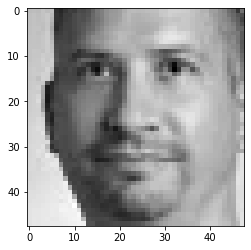

In [205]:
plt.imshow(im, cmap='gray')

In [206]:
val[index][0], val[index][1]

(0, 39)

# torch snippets

In [216]:
import torch_snippets
from torch_snippets import *


In [217]:
print(dir(torch_snippets))

[
    'AttrDict',
    'B',
    'BB',
    'Blank',
    'C',
    'Config',
    'Counter',
    'DataLoader',
    'Dataset',
    'Debug',
    'E',
    'Excep',
    'F',
    'Glob',
    'Image',
    'Info',
    'L',
    'P',
    'PDF',
    'PIL',
    'Permute',
    'Report',
    'Reshape',
    'T',
    'Tqdm',
    'Warn',
    '__builtins__',
    '__cached__',
    '__doc__',
    '__file__',
    '__loader__',
    '__name__',
    '__package__',
    '__path__',
    '__spec__',
    '__version__',
    'batchify',
    'bb_utils',
    'bbfy',
    'bbs2df',
    'choose',
    'common',
    'crop_from_bb',
    'cv2',
    'dcopy',
    'defaultdict',
    'detach',
    'device',
    'df2bbs',
    'diff',
    'dill',
    'display',
    'dumpdill',
    'enlarge_bbs',
    'exists',
    'extn',
    'find',
    'flatten',
    'fname',
    'fname2',
    'ifnone',
    'input_to_str',
    'inspect',
    'inspector',
    'ipython',
    'isdir',
    'isnamedtupleinstance',
    'jitter',
    'line',
    'lines',
    'list_zip',
    'load_defaults',
    'load_torch_model_weights_to',
    'loaddill',
    'loader',
    'loadifexists',
    'logger',
    'lzip',
    'makedir',
    'markup',
    'md5',
    'nn',
    'now',
    'np',
    'nunique',
    'optim',
    'os',
    'output_to_path',
    'pad',
    'parent',
    'paths',
    'pd',
    'pdb',
    'pdf_loader',
    'pdfilter',
    'plt',
    'pretty_json',
    'print',
    'puttext',
    'rand',
    'randint',
    're',
    'read',
    'readPIL',
    'read_json',
    'read_jsonl',
    'read_xml',
    'read_yaml',
    'readlines',
    'rect',
    'registry',
    'remove_duplicates',
    'rename_batch',
    'reset_logger_width',
    'resize',
    'rotate',
    'save_torch_model_weights_from',
    'see',
    'set_logging_level',
    'show',
    'shrink_bbs',
    'stem',
    'stems',
    'store_attr',
    'subplots',
    'sys',
    'th',
    'thinc_parser',
    'to_absolute',
    'to_relative',
    'torch',
    'torch_loader',
    'torchvision',
    'toss',
    'tqdm',
    'track',
    'trange',
    'transforms',
    'typedispatch',
    'uint',
    'unique',
    'unpack',
    'unzip_file',
    'write',
    'write_json',
    'write_jsonl',
    'write_xml',
    'write_yaml',
    'writelines',
    'xywh2xyXY',
    'zip_files'
]

In [218]:
zip_files?

Signature: zip_files(list_of_files, dest)
Docstring: <no docstring>
File:      c:\users\rachi\anaconda3\lib\site-packages\torch_snippets\paths.py
Type:      function
